# Forecast of Chronos from Autogluon


AutoGluon-TimeSeries (AG-TS) includes [Chronos](https://github.com/amazon-science/chronos-forecasting) family of forecasting models. Chronos models are pretrained on a large collection of real & synthetic time series data, which enables them to make accurate forecasts on new data out of the box.

AG-TS provides a robust and easy way to use Chronos through the familiar `TimeSeriesPredictor` API. This tutorial describes how to
- Use Chronos models in **zero-shot** mode to make forecasts without any dataset-specific training
- **Fine-tune** Chronos models on custom data to improve the accuracy
- Handle **covariates & static features** by combining Chronos with a tabular regression model

In [2]:
# We use uv for faster installation
!pip install uv
!uv pip install -q autogluon.timeseries --system
!uv pip uninstall -q torchaudio torchvision torchtext --system # fix incompatible package versions on Colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 66.4 MB/s eta 0:00:00:00:0100:01


## Getting started with Chronos

Being a pretrained model for zero-shot forecasting, Chronos is different from other models available in AG-TS (Autogluon timeseries)
Specifically, Chronos models do not really `fit` time series data. However, when `predict` is called, they carry out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, where all computation happens during inference.

More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

## Zero-shot forecasting

In [62]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#data = TimeSeriesDataFrame.from_path(
##    "https://autogluon.s3.amazonaws.com/datasets/timeseries/australian_electricity_subset/test.csv"
#      "https://github.com/TAUforPython/machinelearning/raw/refs/heads/main/test_datasets/UsdRubTime-AG-TS-format.csv"  
#)

#data.head()

## UsdRubTime-AG-TS-format has a 5 period. See column "item_id" - number of
## item_id is a one of a period.

Next, we create the [TimeSeriesPredictor](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) and select the `"bolt_small"` presets to use the Chronos-Bolt (Small, 48M) model in zero-shot mode.

In [139]:
data = pd.read_csv('/kaggle/input/ecg-timeseries-for-prediction/ecg_1d_timeseries_prediction.csv',
                   delimiter=';')
data['item_id']=1
data = data.rename(columns={"time":"timestamp"})
data = data.rename(columns={"ecg_value":"target"})

#data['timestamp'] = data['timestamp']*1e2
data['timestamp'] = pd.to_datetime(data['timestamp'],unit='h')
#data['timestamp'] = pd.to_timedelta(data['timestamp']*1e2)
#data['timestamp'] = pd.to_datetime(data.timestamp, unit="h").dt.time

data.head(10)

,timestamp,target,item_id
0,1970-01-01 00:00:00.000000000,496,1
1,1970-01-01 00:00:03.600000000,496,1
2,1970-01-01 00:00:07.200000000,497,1
3,1970-01-01 00:00:10.800000000,498,1
4,1970-01-01 00:00:14.400000000,498,1
5,1970-01-01 00:00:18.000000000,499,1
6,1970-01-01 00:00:21.600000000,499,1
7,1970-01-01 00:00:25.200000000,499,1
8,1970-01-01 00:00:28.800000000,499,1
9,1970-01-01 00:00:32.399999999,500,1


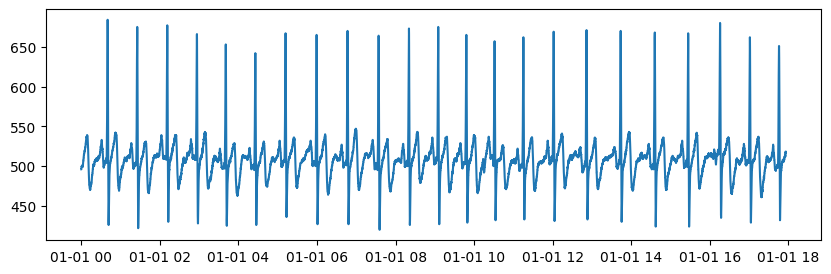

In [140]:
plt.rcParams["figure.figsize"] = (10,3)

plt.plot(data['timestamp'],data['target'])

In [141]:
data = TimeSeriesDataFrame.from_data_frame(data)
data.convert_frequency(freq = "h")
data.head()

target
item_id timestamp                      
1       1970-01-01 00:00:00.000     496
        1970-01-01 00:00:03.600     496
        1970-01-01 00:00:07.200     497
        1970-01-01 00:00:10.800     498
        1970-01-01 00:00:14.400     498

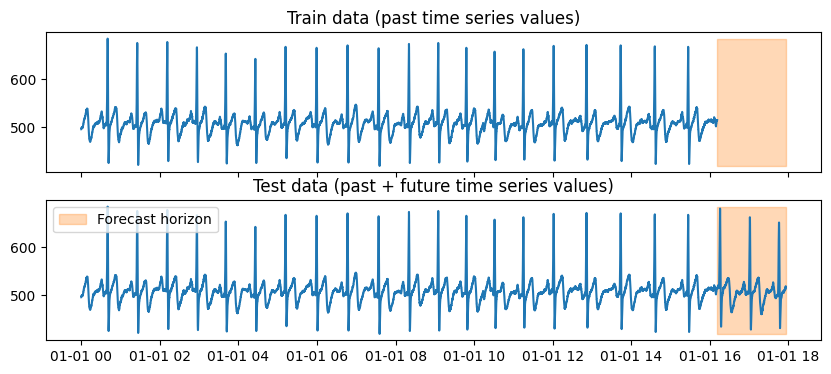

In [142]:
prediction_length = 1750
train_data, test_data = data.train_test_split(prediction_length)

item_id = 1
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 4], sharex=True)
train_ts = train_data.loc[item_id]
test_ts = test_data.loc[item_id]
ax1.set_title("Train data (past time series values)")
ax1.plot(train_ts)
ax2.set_title("Test data (past + future time series values)")
ax2.plot(test_ts)
for ax in (ax1, ax2):
    ax.fill_between(np.array([train_ts.index[-1], test_ts.index[-1]]), test_ts.min(), test_ts.max(), color="C1", alpha=0.3, label="Forecast horizon")
plt.legend()
plt.show()

17935

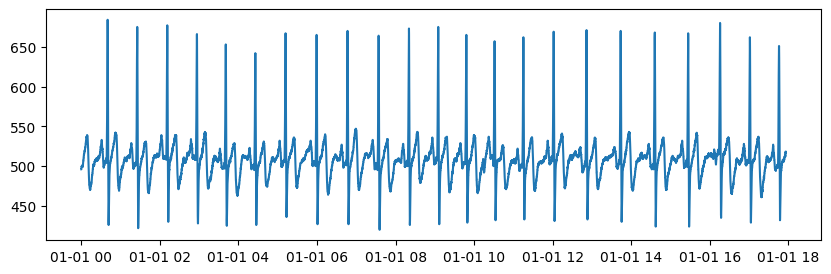

In [151]:
data_ts = data.loc[item_id]
plt.plot(data_ts)
len(data_ts)

In [152]:
print(len(test_ts), len(train_ts), len(test_ts)-len(train_ts))

17935 16185 1750


In [146]:
predictor = TimeSeriesPredictor(freq="h",
                                prediction_length=prediction_length, 
                                eval_metric="MASE").fit(train_data,
                                                        presets="bolt_base",
                                                        num_val_windows=300)
#predictor.evaluate(test_data)

predictions = predictor.predict(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20250321_194841"
Beginning AutoGluon training...
AutoGluon will save models to '/kaggle/working/AutogluonModels/ag-20250321_194841'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
GPU Count:          0
Memory Avail:       29.67 GB / 31.35 GB (94.6%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 300,
 'prediction_length': 1750,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 '

Let's use the `predict` method to generate forecasts, and the `plot` method to visualize them.

data with frequency 'None' has been resampled to frequency 'h'.


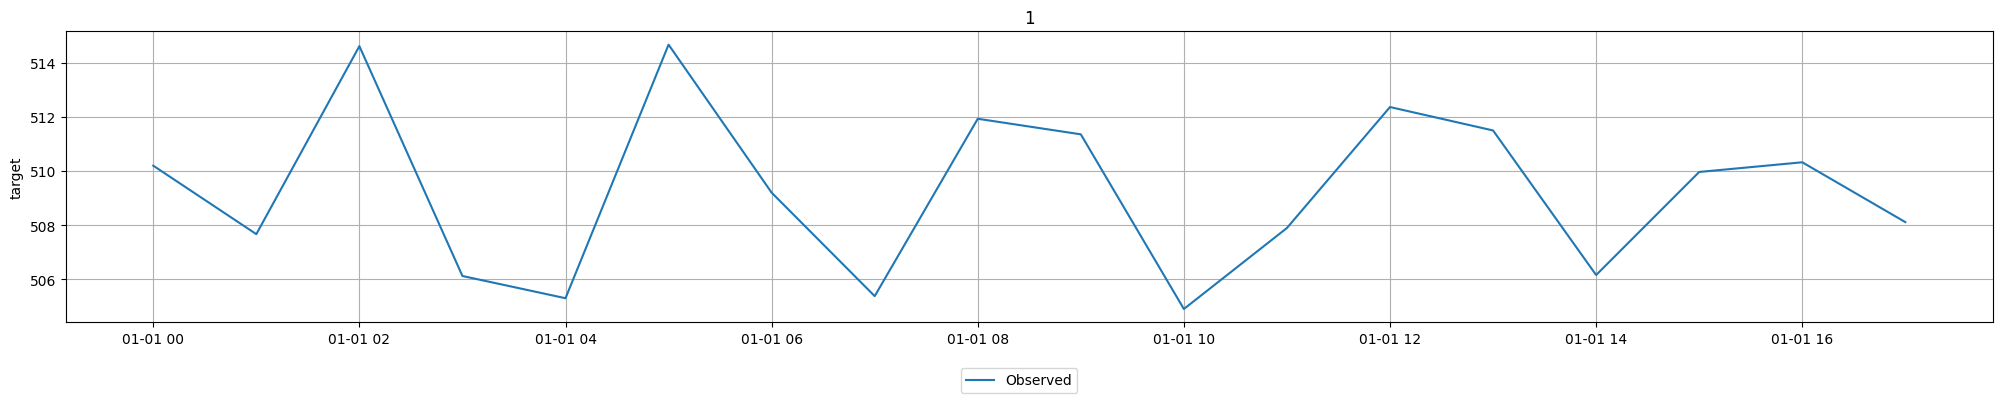

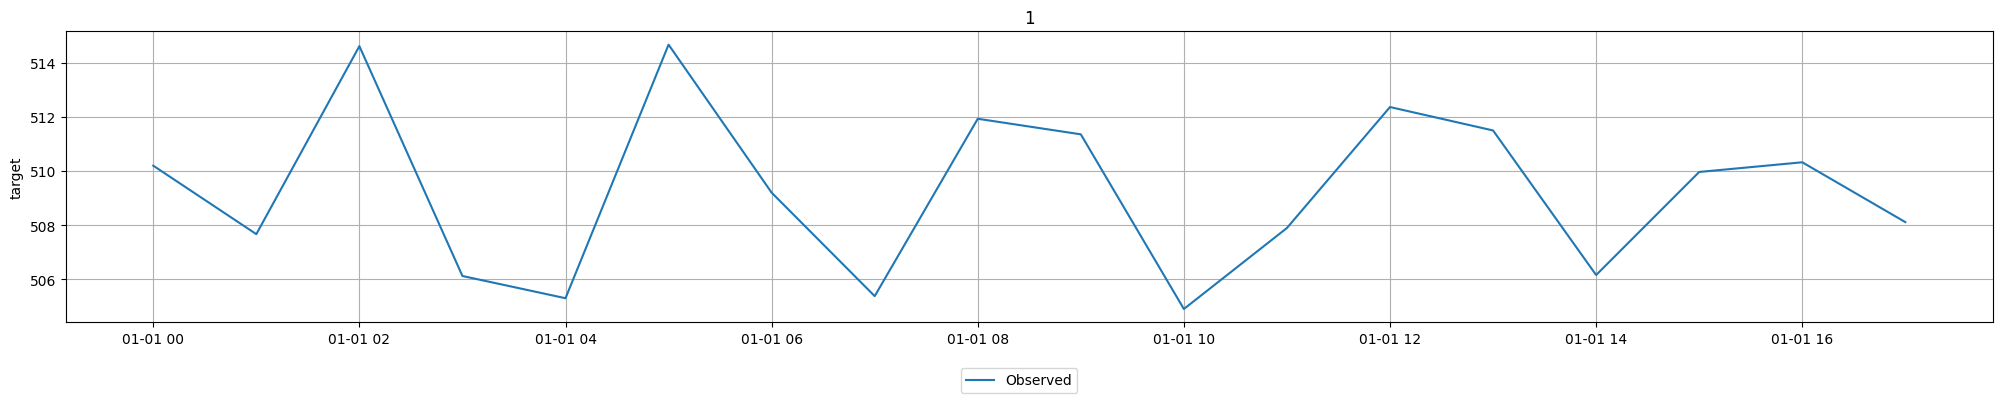

In [147]:
predictor.plot(data=data, max_num_item_ids=1)

In [131]:
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:1],
    max_history_length=16,
);

KeyError: 'target'

1750


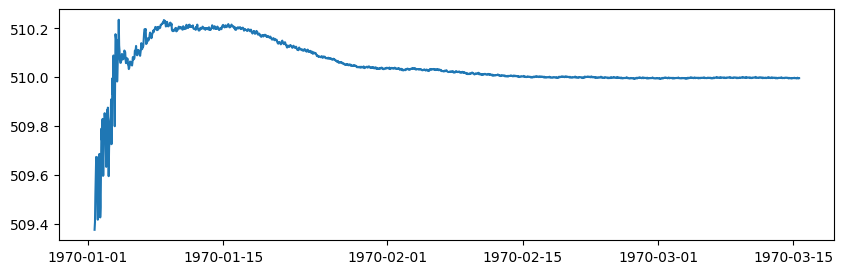

In [159]:
forecast_ts = predictions.loc[item_id]['mean']
print(len(forecast_ts))
plt.plot(forecast_ts)

In [ ]:
data_ts = data.loc[item_id]
plt.plot(data_ts)
len(data_ts)

data with frequency 'None' has been resampled to frequency 'h'.


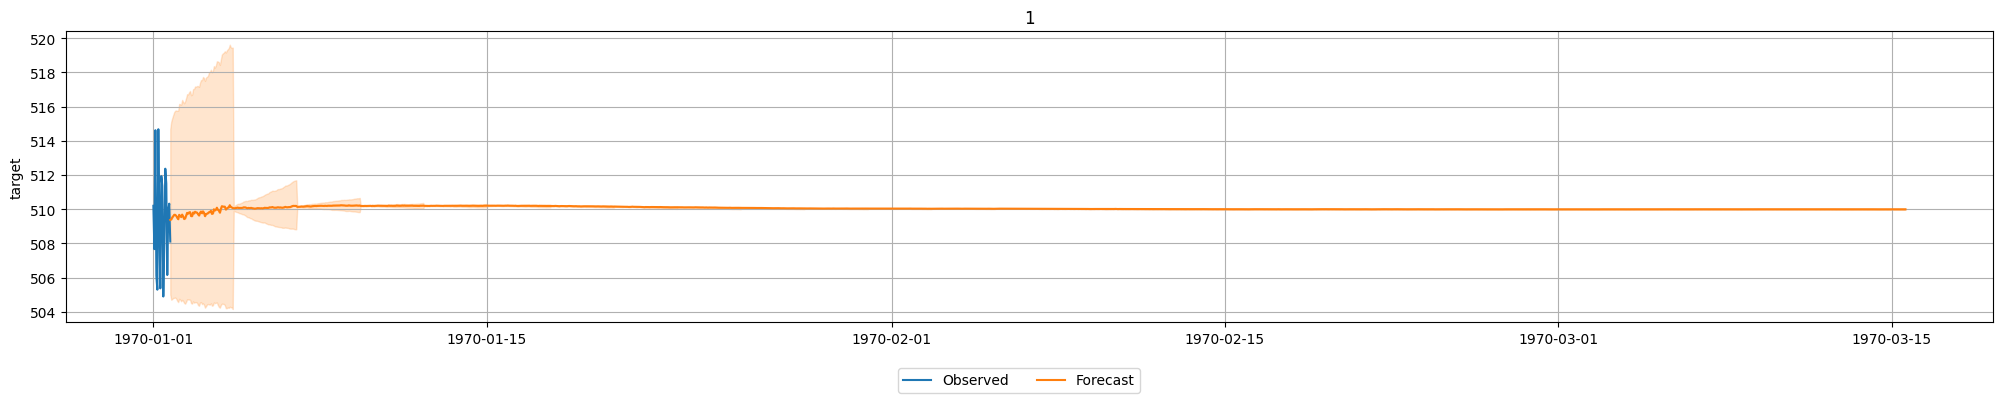

In [100]:
predictor.plot(test_data, predictions, 
               quantile_levels=[0.1, 0.9], 
               max_history_length=200, 
               max_num_item_ids=1);

Covariates are the time-varying features that may influence the target time series. They are sometimes also referred to as dynamic features, exogenous regressors, or related time series. AutoGluon supports two types of covariates:

known covariates that are known for the entire forecast horizon, such as

* holidaysday of the week,
* month,
* yearpromotions

past covariates that are only known up to the start of the forecast horizon, such as

* sales of other products
* temperature, precipitation
* transformed target time series


## Fine-tuning

We have seen above how Chronos models can produce forecasts in zero-shot mode. AutoGluon also makes it easy to fine-tune Chronos models on a specific dataset to maximize the predictive accuracy.

The following snippet specifies two settings for the Chronos-Bolt ️(Small) model: zero-shot and fine-tuned. `TimeSeriesPredictor` will perform a lightweight fine-tuning of the pretrained model on the provided training data. We add name suffixes to easily identify the zero-shot and fine-tuned versions of the model.

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)


After fitting, we can evaluate the two model variants on the test data and generate a leaderboard.

In [ ]:
modelname = predictor.leaderboard(test_data)
modelname['model'][0]

In [ ]:
predictions = predictor.predict(train_data, model = modelname['model'][0])
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:5],
    max_history_length=200,
);

## Incorporating the covariates

Chronos️ is a univariate model, meaning it relies solely on the historical data of the target time series for making predictions. However, in real-world scenarios, additional exogenous information related to the target series (e.g., holidays, promotions) is often available. Leveraging this information when making predictions can improve forecast accuracy.

Covariates are continuous independent variables (or predictors) in a regression or ANOVA model. These variables can explain some of the variability in the dependent variable. Any measurable variable that has a statistical relationship with the dependent variable qualifies as a covariate.

AG-TS now features covariate regressors that can be combined with univariate models like Chronos-Bolt to incorporate exogenous information.
A `covariate_regressor` in AG-TS is a tabular regression model that is fit on the known covariates and static features to predict the target column at the each time step. The predictions of the covariate regressor are subtracted from the target column, and the univariate model then forecasts the residuals.

In [ ]:
data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/grocery_sales/test.csv",
)
data.head()

We use a grocery sales dataset to demonstrate how Chronos-Bolt can be combined with a covariate regressor. This dataset includes 3 known covariates: `scaled_price`, `promotion_email` and `promotion_homepage` and the task is to forecast the `unit_sales`.

In [ ]:
prediction_length = 8
train_data, test_data = data.train_test_split(prediction_length=prediction_length)

The following code fits a TimeSeriesPredictor to forecast `unit_sales` for the next 8 weeks.

Note that we have specified the target column we are interested in forecasting and the names of known covariates while constructing the TimeSeriesPredictor.

We define two configurations for Chronos-Bolt:
- zero-shot configuration that uses only the historical values of `unit_sales` without considering the covariates;
- a configuration with a CatBoost regression model as the `covariate_regressor`. Note that we recommend to apply a `target_scaler` when using a covariate regressor. Target scaler ensures that all time series have comparable scales, often leading to better accuracy.

Like before, we add suffixes to model names to more easily distinguish them in the leaderboard.

In [ ]:
train_data

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="unit_sales",
    known_covariates_names=["scaled_price", "promotion_email", "promotion_homepage"],

).fit(
    train_data,
    hyperparameters={
        "Chronos": [
            # Zero-shot model WITHOUT covariates
            {
                "model_path": "bolt_small",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            # Chronos-Bolt (Small) combined with CatBoost on covariates
            {
                "model_path": "bolt_small",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },
        ],
    },
    enable_ensemble=False,
    time_limit=60,
)

Once the predictor has been fit, we can evaluate it on the test dataset and generate the leaderboard. We see that the model that utilizes the covariates produces a more accurate forecast on the test set.

In [ ]:
fimportance = TimeSeriesPredictor.feature_importance(predictor)
fimportance = fimportance.sort_values('importance')

plt.figure(figsize=(12,5))
plt.barh(fimportance.index, fimportance['importance'])
plt.title('Importance')
plt.show()

In [ ]:
predictor.leaderboard(test_data)

Note that the covariates may not always be useful — for some datasets, the zero-shot model may achieve better accuracy. Therefore, it's always important to try out multiple models and select the one that achieves the best accuracy on held-out data. This is done automatically in AutoGluon's `"high_quality"` and `"best_quality"` presets.

# Forecast of Chronos from Amazon

In [161]:
# Install Chronos
!pip install git+https://github.com/amazon-science/chronos-forecasting.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [162]:
# Import Libraries To Use
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
import warnings
warnings.filterwarnings("ignore")

In [167]:
data = pd.read_csv('/kaggle/input/ecg-timeseries-for-prediction/ecg_1d_timeseries_prediction.csv',
                   delimiter=';')
data['item_id']=1
data = data.rename(columns={"time":"timestamp"})
data = data.rename(columns={"ecg_value":"target"})
data.head()
#data['target']

,timestamp,target,item_id
0,0.000,496,1
1,0.001,496,1
2,0.002,497,1
3,0.003,498,1
4,0.004,498,1


In [172]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.float32, 
)


context = torch.tensor(data["target"])
prediction_length = 1200
forecast = pipeline.predict(context, prediction_length);  # shape [num_series, num_samples, prediction_length]

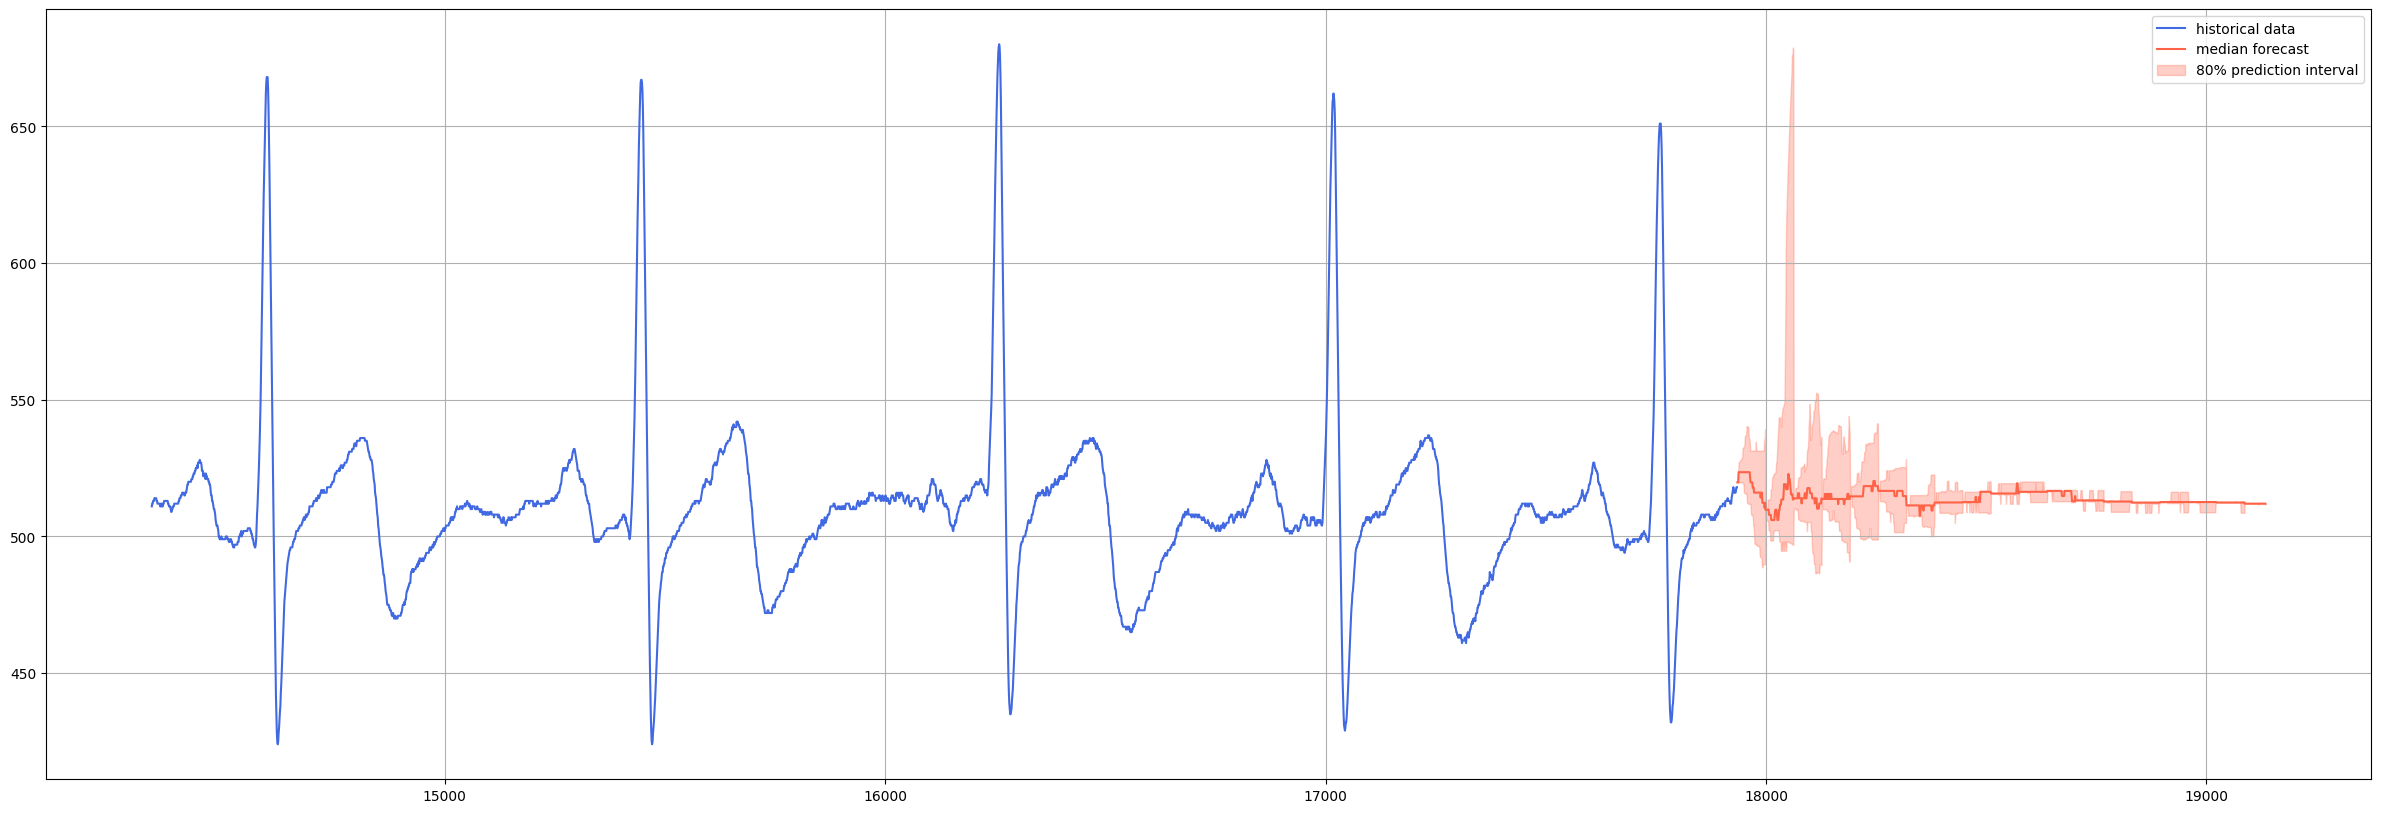

In [180]:
# visualize the forecast
forecast_index = range(len(data), len(data) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(30, 10))
plt.plot(data["target"][-prediction_length*3:], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()